## Model Training Work

In [1]:
# Libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date

# Set float display to avoid scientific notation
pd.set_option('display.float_format', '{:.2f}'.format)

# Wranings 
import warnings
warnings.filterwarnings('ignore')

StatementMeta(, eee831f5-adcb-4ac9-8631-db81d0f5b66c, 3, Finished, Available, Finished)

### Read Data

In [2]:
# Read data 
train_df = pd.read_parquet("/lakehouse/default/Files/engineered/train_df6.parquet")
train_df.head()

StatementMeta(, eee831f5-adcb-4ac9-8631-db81d0f5b66c, 4, Finished, Available, Finished)

,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,...,pickup_dayofmonth_26,pickup_dayofmonth_27,pickup_dayofmonth_28,pickup_dayofmonth_29,pickup_dayofmonth_30,time_of_day_Evening,time_of_day_Morning,time_of_day_Night,is_high_tip_1,is_night_ride_1
0,1.36,0.82,0.82,-0.36,0.67,0.83,-0.74,-0.31,-0.45,3.51,...,0,0,0,0,0,0,0,0,0,0
1,1.10,1.36,-0.78,-0.36,-0.71,-0.63,-0.74,-0.31,-0.45,3.26,...,0,0,0,0,0,1,0,0,0,0
2,-1.06,-1.31,-1.13,-0.36,-0.93,-0.88,-0.74,-0.31,-0.45,1.89,...,0,0,0,0,0,0,1,0,0,0
3,0.55,0.20,0.60,-0.36,0.35,0.60,1.36,-0.31,1.68,3.01,...,0,0,0,0,0,0,0,1,0,1
4,-0.12,0.50,-0.56,-0.36,-0.60,-0.46,-0.74,-0.31,-0.45,2.86,...,0,0,0,0,0,1,0,0,0,0


In [3]:
# Shape 
train_df.shape

StatementMeta(, eee831f5-adcb-4ac9-8631-db81d0f5b66c, 5, Finished, Available, Finished)

(2000000, 82)

In [4]:
# Info 
train_df.info()

StatementMeta(, eee831f5-adcb-4ac9-8631-db81d0f5b66c, 6, Finished, Available, Finished)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 82 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   trip_miles                float64
 1   trip_time                 float64
 2   base_passenger_fare       float64
 3   tolls                     float64
 4   bcf                       float64
 5   sales_tax                 float64
 6   congestion_surcharge      float64
 7   airport_fee               float64
 8   tips                      float64
 9   driver_pay                float64
 10  cbd_congestion_fee        float64
 11  driver_pay_per_mile       float64
 12  hvfhs_license_num_HV0005  int64  
 13  shared_request_flag_1     int64  
 14  shared_match_flag_1       int64  
 15  access_a_ride_flag_1      int64  
 16  wav_request_flag_1        int64  
 17  wav_match_flag_1          int64  
 18  pickup_hour_1             int64  
 19  pickup_hour_2             int64  
 20  pickup_hour_3           

### Correlations

In [5]:
# describe Continuous features 
train_df.select_dtypes('float64').describe()

StatementMeta(, eee831f5-adcb-4ac9-8631-db81d0f5b66c, 7, Finished, Available, Finished)

,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,cbd_congestion_fee,driver_pay_per_mile
count,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00,2000000.00
mean,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,2.87,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.68,1.00,1.00
min,-1.59,-2.36,-1.76,-0.36,-1.25,-2.15,-0.74,-0.31,-0.45,1.61,-0.71,-1.70
25%,-0.81,-0.70,-0.77,-0.36,-0.73,-0.70,-0.74,-0.31,-0.45,2.35,-0.71,-0.70
50%,-0.17,0.02,-0.12,-0.36,-0.28,-0.15,-0.74,-0.31,-0.45,2.84,-0.71,-0.11
75%,0.69,0.71,0.65,-0.36,0.47,0.59,1.36,-0.31,-0.45,3.34,1.40,0.51
max,2.60,2.25,2.69,3.73,3.49,2.81,1.36,3.19,3.51,4.53,1.40,3.38


In [6]:
# Set continuous features 
continuous_features = train_df.select_dtypes('float64').columns

StatementMeta(, eee831f5-adcb-4ac9-8631-db81d0f5b66c, 8, Finished, Available, Finished)

StatementMeta(, eee831f5-adcb-4ac9-8631-db81d0f5b66c, 9, Finished, Available, Finished)

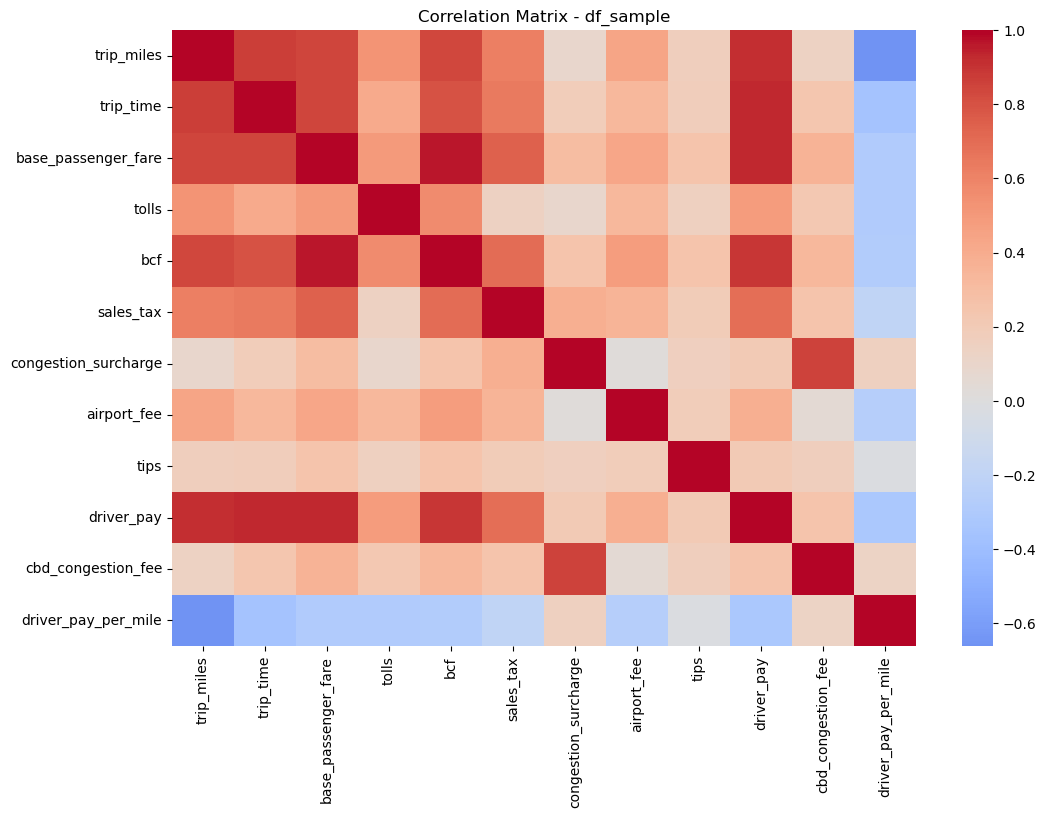

driver_pay              1.00
trip_time               0.93
base_passenger_fare     0.93
trip_miles              0.91
bcf                     0.89
sales_tax               0.69
tolls                   0.48
airport_fee             0.39
cbd_congestion_fee      0.26
tips                    0.20
congestion_surcharge    0.20
driver_pay_per_mile    -0.32
Name: driver_pay, dtype: float64


In [7]:
# calculate correlations only for numeric columns (continous only, not categorical)
corr_matrix = train_df.select_dtypes(include='float64').corr(numeric_only=True)

# display as heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Matrix - df_sample")
plt.show()

# if you want to check only correlation with the target
print(corr_matrix['driver_pay'].sort_values(ascending=False))

### Selecting Features (X), Target (y)

In [8]:
# Columns 
train_df.columns

StatementMeta(, eee831f5-adcb-4ac9-8631-db81d0f5b66c, 10, Finished, Available, Finished)

Index(['trip_miles', 'trip_time', 'base_passenger_fare', 'tolls', 'bcf',
       'sales_tax', 'congestion_surcharge', 'airport_fee', 'tips',
       'driver_pay', 'cbd_congestion_fee', 'driver_pay_per_mile',
       'hvfhs_license_num_HV0005', 'shared_request_flag_1',
       'shared_match_flag_1', 'access_a_ride_flag_1', 'wav_request_flag_1',
       'wav_match_flag_1', 'pickup_hour_1', 'pickup_hour_2', 'pickup_hour_3',
       'pickup_hour_4', 'pickup_hour_5', 'pickup_hour_6', 'pickup_hour_7',
       'pickup_hour_8', 'pickup_hour_9', 'pickup_hour_10', 'pickup_hour_11',
       'pickup_hour_12', 'pickup_hour_13', 'pickup_hour_14', 'pickup_hour_15',
       'pickup_hour_16', 'pickup_hour_17', 'pickup_hour_18', 'pickup_hour_19',
       'pickup_hour_20', 'pickup_hour_21', 'pickup_hour_22', 'pickup_hour_23',
       'pickup_dayofweek_1', 'pickup_dayofweek_2', 'pickup_dayofweek_3',
       'pickup_dayofweek_4', 'pickup_dayofweek_5', 'pickup_dayofweek_6',
       'is_weekend_1', 'pickup_dayofmonth_2',

In [9]:
# Target 
y = train_df['driver_pay']

# Features (change per modelling demands)
X = train_df[['trip_time', 'tolls', 'congestion_surcharge', 'airport_fee', 
        'tips', 'hvfhs_license_num_HV0005', 'shared_match_flag_1', 
        'access_a_ride_flag_1', 'wav_match_flag_1', 'is_weekend_1', 
        'time_of_day_Evening', 'time_of_day_Morning', 'time_of_day_Night']]

StatementMeta(, eee831f5-adcb-4ac9-8631-db81d0f5b66c, 11, Finished, Available, Finished)

In [10]:
# Shape
X.shape

StatementMeta(, eee831f5-adcb-4ac9-8631-db81d0f5b66c, 12, Finished, Available, Finished)

(2000000, 13)

### Train Test Split 

In [11]:
# Train - test split 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

StatementMeta(, eee831f5-adcb-4ac9-8631-db81d0f5b66c, 13, Finished, Available, Finished)

###  Baseline Model

#### VIF
Best on sample data

In [12]:
# Sample
X_sample = X.sample(n=100000, random_state=100)
X_sample.head()

StatementMeta(, db415e8f-1383-4e89-8807-191c83521c21, 14, Finished, Available, Finished)

,trip_time,tolls,congestion_surcharge,airport_fee,tips,hvfhs_license_num_HV0005,shared_match_flag_1,access_a_ride_flag_1,wav_match_flag_1,is_weekend_1,time_of_day_Evening,time_of_day_Morning,time_of_day_Night
652361,-1.62,-0.35,-0.77,-0.29,-0.45,0,0,0,0,0,0,0,0
987120,-0.68,-0.35,1.31,-0.29,-0.45,0,0,0,1,0,0,1,0
1110434,0.40,-0.35,1.31,-0.29,-0.45,0,0,0,1,0,0,0,1
1082790,-0.09,-0.35,1.31,-0.29,1.44,0,0,0,0,1,0,1,0
1982922,1.48,-0.35,-0.77,3.52,-0.45,0,0,0,1,0,0,0,1


In [43]:
# Caculating VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

# features dataframe is 'X' (no traget variable)

def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_sample.columns
    vif_data["VIF"] = [variance_inflation_factor(X_sample.values, i) for i in range(X_sample.shape[1])]
    return vif_data

# Example usage:
vif_df = calculate_vif(X)   # replace 'features' with your dataframe of independent variables
print(vif_df)

StatementMeta(, e6a2991c-5fea-4684-85a2-d02c3f4b4267, 45, Finished, Available, Finished)

                     Feature  VIF
0                  trip_time 1.31
1                      tolls 1.30
2       congestion_surcharge 1.06
3                airport_fee 1.22
4                       tips 1.07
5   hvfhs_license_num_HV0005 1.26
6        shared_match_flag_1 1.06
7       access_a_ride_flag_1 1.00
8           wav_match_flag_1 1.09
9               is_weekend_1 1.26
10       time_of_day_Evening 1.22
11       time_of_day_Morning 1.14
12         time_of_day_Night 1.14


In [44]:
# Results
display(vif_df)

StatementMeta(, e6a2991c-5fea-4684-85a2-d02c3f4b4267, 46, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 32717c66-d635-4fa7-ad80-ff5f63c2f5c4)

#### LR Model (sklearn)

In [12]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

StatementMeta(, eee831f5-adcb-4ac9-8631-db81d0f5b66c, 14, Finished, Available, Finished)

LinearRegression()

#### Evaluation

In [13]:
# Model Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_pred = lr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

StatementMeta(, eee831f5-adcb-4ac9-8631-db81d0f5b66c, 15, Finished, Available, Finished)

RMSE: 0.21
MAE: 0.16
R²: 0.90


#### Predictions

In [14]:
# predictions for training and test 
train_predictions = lr.predict(X_train)
test_predictions = lr.predict(X_test)

StatementMeta(, eee831f5-adcb-4ac9-8631-db81d0f5b66c, 16, Finished, Available, Finished)

In [15]:
# Shape 
print("Shape of train predictions:" ,train_predictions.shape ) 
print("Shape of test predictions:" ,test_predictions.shape)

StatementMeta(, eee831f5-adcb-4ac9-8631-db81d0f5b66c, 17, Finished, Available, Finished)

Shape of train predictions: (1600000,)
Shape of test predictions: (400000,)


**Confirmation**: Train data split is 80% of train_df and Test data split is 20% of train_df

In [16]:
# Get predictions to original scale (before log transformation)
train_predictions_exp = np.expm1(train_predictions)          # log(1+x)
test_predictions_exp = np.expm1(test_predictions)            # log(1+x)

# Set target variable (driver_pay) to original scale 
train_actuals_exp = np.expm1(y_train)
test_actuals_exp = np.expm1(y_test)

StatementMeta(, eee831f5-adcb-4ac9-8631-db81d0f5b66c, 18, Finished, Available, Finished)

In [17]:
# test results with actuals and predictions
test_results = pd.DataFrame({
    "actual_pay": test_actuals_exp,
    "predicted_pay": pd.Series(test_predictions_exp, index=test_actuals_exp.index),
    "series": "test"
})
test_results

StatementMeta(, eee831f5-adcb-4ac9-8631-db81d0f5b66c, 19, Finished, Available, Finished)

,actual_pay,predicted_pay,series
1828401,4.98,4.85,test
1200071,9.97,11.28,test
194849,24.25,22.27,test
1629054,14.87,35.75,test
191144,91.44,89.23,test
...,...,...,...
1171220,47.65,45.06,test
1409796,10.19,12.48,test
1150185,44.15,34.18,test
1681689,29.96,33.60,test


In [18]:
# train results with actuals and predictions
train_results = pd.DataFrame({
    "actual_pay": train_actuals_exp,
    "predicted_pay": pd.Series(train_predictions_exp, index=train_actuals_exp.index),
    "series": "train"
})
train_results

StatementMeta(, eee831f5-adcb-4ac9-8631-db81d0f5b66c, 20, Finished, Available, Finished)

,actual_pay,predicted_pay,series
399734,13.52,14.76,train
1750629,57.83,29.97,train
1102528,28.69,14.29,train
1910924,9.54,10.63,train
790025,12.63,13.55,train
...,...,...,...
259178,12.53,14.10,train
1414414,12.83,14.93,train
131932,13.98,16.88,train
671155,4.84,5.10,train


In [19]:
# Vertically concatenate train and test series 
results_df = pd.concat([train_results, test_results], axis=0)
results_df

StatementMeta(, eee831f5-adcb-4ac9-8631-db81d0f5b66c, 21, Finished, Available, Finished)

,actual_pay,predicted_pay,series
399734,13.52,14.76,train
1750629,57.83,29.97,train
1102528,28.69,14.29,train
1910924,9.54,10.63,train
790025,12.63,13.55,train
...,...,...,...
1171220,47.65,45.06,test
1409796,10.19,12.48,test
1150185,44.15,34.18,test
1681689,29.96,33.60,test


In [20]:
# Shape 
results_df.shape

StatementMeta(, eee831f5-adcb-4ac9-8631-db81d0f5b66c, 22, Finished, Available, Finished)

(2000000, 3)

In [21]:
# Read original training data 
train_df = pd.read_parquet("/lakehouse/default/Files/engineered/train_df1.parquet")
train_df.head()

StatementMeta(, eee831f5-adcb-4ac9-8631-db81d0f5b66c, 23, Finished, Available, Finished)

,hvfhs_license_num,pickup_datetime,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,congestion_surcharge,airport_fee,...,access_a_ride_flag,wav_request_flag,wav_match_flag,cbd_congestion_fee,week_number,pickup_hour,pickup_dayofweek,is_weekend,pickup_dayofmonth,time_of_day
11322195,HV0003,2025-06-18 12:40:39,10.95,1683,37.72,0.00,0.95,3.35,0.00,0.00,...,N,N,N,0.00,25,12,2,0,18,Afternoon
12984601,HV0003,2025-06-20 21:29:28,8.89,2445,12.59,0.00,0.32,1.12,0.00,0.00,...,N,N,N,0.00,25,21,4,0,20,Evening
5431662,HV0003,2025-06-09 10:31:29,1.15,395,9.82,0.00,0.24,0.87,0.00,0.00,...,N,N,N,0.00,24,10,0,0,9,Morning
15867325,HV0003,2025-06-25 02:08:11,5.74,1110,32.51,0.00,0.78,2.89,2.75,0.00,...,N,N,N,1.50,26,2,2,0,25,Night
13701913,HV0003,2025-06-21 20:52:19,3.17,1360,14.68,0.00,0.36,1.30,0.00,0.00,...,N,N,N,0.00,25,20,5,1,21,Evening


In [22]:
train_df = train_df.reset_index(drop=True)
train_df.head()

StatementMeta(, eee831f5-adcb-4ac9-8631-db81d0f5b66c, 24, Finished, Available, Finished)

,hvfhs_license_num,pickup_datetime,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,congestion_surcharge,airport_fee,...,access_a_ride_flag,wav_request_flag,wav_match_flag,cbd_congestion_fee,week_number,pickup_hour,pickup_dayofweek,is_weekend,pickup_dayofmonth,time_of_day
0,HV0003,2025-06-18 12:40:39,10.95,1683,37.72,0.00,0.95,3.35,0.00,0.00,...,N,N,N,0.00,25,12,2,0,18,Afternoon
1,HV0003,2025-06-20 21:29:28,8.89,2445,12.59,0.00,0.32,1.12,0.00,0.00,...,N,N,N,0.00,25,21,4,0,20,Evening
2,HV0003,2025-06-09 10:31:29,1.15,395,9.82,0.00,0.24,0.87,0.00,0.00,...,N,N,N,0.00,24,10,0,0,9,Morning
3,HV0003,2025-06-25 02:08:11,5.74,1110,32.51,0.00,0.78,2.89,2.75,0.00,...,N,N,N,1.50,26,2,2,0,25,Night
4,HV0003,2025-06-21 20:52:19,3.17,1360,14.68,0.00,0.36,1.30,0.00,0.00,...,N,N,N,0.00,25,20,5,1,21,Evening


In [23]:
# Shape 
train_df.shape

StatementMeta(, eee831f5-adcb-4ac9-8631-db81d0f5b66c, 25, Finished, Available, Finished)

(2000000, 24)

In [24]:
# Final df - train, test, predictions
final_df = pd.concat([train_df, results_df], axis=1)
display(final_df)

StatementMeta(, eee831f5-adcb-4ac9-8631-db81d0f5b66c, 26, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 8b7346c5-528f-4713-9b53-3078fb7bf96c)

In [25]:
# Driver pay side by side
final_df[['driver_pay', 'actual_pay', 'predicted_pay']]

StatementMeta(, eee831f5-adcb-4ac9-8631-db81d0f5b66c, 27, Finished, Available, Finished)

,driver_pay,actual_pay,predicted_pay
0,32.46,32.46,25.15
1,25.17,25.17,25.06
2,5.61,5.61,6.59
3,19.30,19.30,21.25
4,16.53,16.53,15.10
...,...,...,...
1999995,22.00,22.00,21.06
1999996,44.22,44.22,40.99
1999997,11.17,11.17,12.58
1999998,66.08,66.08,33.92


#### LR model (Statsmodel)
for better inference

In [26]:
import statsmodels.api as sm

# Suppose X_train, y_train are your features and target
# Add constant (intercept)
X_train_const = sm.add_constant(X_train)

# Fit OLS regression
model = sm.OLS(y_train, X_train_const).fit()

# Print full summary
print(model.summary())

StatementMeta(, eee831f5-adcb-4ac9-8631-db81d0f5b66c, 28, Finished, Available, Finished)

                            OLS Regression Results                            
Dep. Variable:             driver_pay   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                 1.126e+06
Date:                Fri, 26 Sep 2025   Prob (F-statistic):               0.00
Time:                        07:08:58   Log-Likelihood:             1.9980e+05
No. Observations:             1600000   AIC:                        -3.996e+05
Df Residuals:                 1599986   BIC:                        -3.994e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

#### Save model to lakehouse 

In [27]:
## Saving Linear Regression model (1st run)
import os

# Define models folder inside Lakehouse Files
models_path = "/lakehouse/default/Files/models/"

# Create folder if it doesn't exist
os.makedirs(models_path, exist_ok=True)

# Save the model
import joblib
joblib.dump(lr, os.path.join(models_path, "lr_sklearn.pkl"))

StatementMeta(, eee831f5-adcb-4ac9-8631-db81d0f5b66c, 29, Finished, Available, Finished)

['/lakehouse/default/Files/models/lr_sklearn.pkl']

In [29]:
final_df.head()

StatementMeta(, eee831f5-adcb-4ac9-8631-db81d0f5b66c, 31, Finished, Available, Finished)

,hvfhs_license_num,pickup_datetime,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,congestion_surcharge,airport_fee,...,cbd_congestion_fee,week_number,pickup_hour,pickup_dayofweek,is_weekend,pickup_dayofmonth,time_of_day,actual_pay,predicted_pay,series
0,HV0003,2025-06-18 12:40:39,10.95,1683,37.72,0.00,0.95,3.35,0.00,0.00,...,0.00,25,12,2,0,18,Afternoon,32.46,25.15,train
1,HV0003,2025-06-20 21:29:28,8.89,2445,12.59,0.00,0.32,1.12,0.00,0.00,...,0.00,25,21,4,0,20,Evening,25.17,25.06,train
2,HV0003,2025-06-09 10:31:29,1.15,395,9.82,0.00,0.24,0.87,0.00,0.00,...,0.00,24,10,0,0,9,Morning,5.61,6.59,train
3,HV0003,2025-06-25 02:08:11,5.74,1110,32.51,0.00,0.78,2.89,2.75,0.00,...,1.50,26,2,2,0,25,Night,19.30,21.25,test
4,HV0003,2025-06-21 20:52:19,3.17,1360,14.68,0.00,0.36,1.30,0.00,0.00,...,0.00,25,20,5,1,21,Evening,16.53,15.10,train


In [28]:
# Save training data with predictions to fabric warehouse 
spark.createDataFrame(final_df).write.format("delta").mode(
            "overwrite").option("overwriteSchema", "true").saveAsTable("trained_final_df")

StatementMeta(, eee831f5-adcb-4ac9-8631-db81d0f5b66c, 30, Finished, Available, Finished)